## Importing Libraries

In [3]:
import re

import pandas as pd
import re, string
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pylab
import seaborn as sns

from pathlib import Path
from collections import Counter
from multiprocessing import Pool
from urllib.parse import urlparse

%matplotlib inline

In [5]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer, MultiLabelBinarizer

In [3]:
path = Path('Data/')

In [ ]:
import seaborn as sns

## Reading in data from pkl file

In [8]:
df = pd.read_pickle('../Data/Finale.pkl')
# df.to_pickle('Data/Finale.pkl')

In [9]:
df.columns

Index(['ups', 'link_id', 'name', 'subreddit', 'gilded', 'score',
       'retrieved_on', 'body', 'distinguished', 'edited', 'controversiality',
       'parent_id', 'is_flair', 'is_flair_css', 'time', 'url', 'num_comments',
       'over_18', 'link_score', 'selftext', 'title', 'upvote_ratio',
       'link_ups', 'link_created_time', 'time_since_link', 'depth',
       'linked_sr', 'linked_urls', 'no_of_linked_sr', 'no_of_linked_urls',
       'a_linked_urls', 'a_linked_sr', 'parent_score', 'comment_tree_root_id',
       'comment_tree_root_score', 'time_since_comment_tree_root',
       'subjectivity', 'is_edited', 'senti_neg', 'senti_neu', 'senti_pos',
       'senti_comp', 'is_quoted', 'no_quoted', 'time_since_parent', 'is_root',
       'is_selftext', 'word_counts', 'epoch_time', 'no_of_past_comments',
       'score_till_now', 'parent_cosine', 'parent_euc', 'cosine_euc',
       'title_cosine', 'title_euc', 'no_of_quoted_users', 'hour_of_comment',
       'weekday', 'title_url_in_top'],
      d

We want to split these into three broad categories, and thus treat them accordingly:

* **Categorical Variables** - `subreddit`, `distinguished`, `is_flair`, `is_flair_css`, `hour_of_comment`, `weekday`

* **Boolean Variables** - `over_18`, `is_edited`, `is_quoted`, `is_selftext`, `title_url_in_top`

* **Numeric Variables** - `gilded`, `controversiality`, `num_comments`, `link_score`, `upvote_ratio`, `link_ups`, `time_since_link`, `depth`, `no_of_linked_sr`, `no_of_linked_urls`, `parent_score`, `comment_tree_root_score`, `time_since_comment_tree_root`, `subjectivity`, `senti_neg`, `senti_pos`, `senti_neu`, `senti_comp`, `no_quoted`, `time_since_parent`, `word_counts`, `title_cos_angle`, `parent_cos_angle`

In [4]:
cat_cols = ['subreddit', 'distinguished', 'is_flair', 'is_flair_css','hour_of_comment', 'weekday']
bool_cols = ['over_18', 'is_edited', 'is_quoted', 'is_selftext',
             'title_url_in_top']

numeric_cols = ['gilded', 'controversiality', 'upvote_ratio','time_since_link',
                'depth', 'no_of_linked_sr', 'no_of_linked_urls', 'parent_score',
                'comment_tree_root_score', 'time_since_comment_tree_root',
                'subjectivity', 'senti_neg', 'senti_pos', 'senti_neu',
                'senti_comp', 'no_quoted', 'time_since_parent', 'word_counts',
                'no_of_past_comments', 'parent_cosine','parent_euc',
                'title_cosine', 'title_euc', 'no_of_quoted_users','link_score']

Most of the comments are roots, which we will have to remove. We get a high R squared value if we keep them in the model, but that is cheating, because for these comments, `comment_tree_root_score` is exactly equal to the `score`.

Hence, we will be predicting only for comments that are not the tree's roots themselves.

In [6]:
# Removing comments that are not roots

df = df.loc[df.is_root == False]

In [7]:
from scipy.sparse import hstack

The variables above will be transformed as the following:
* **Categorical columns:** Transformed using sklearn's `LabelBinarizer()`
* **Boolean columns:** Transformed to integer
* **Numeric columns:** Take them as is

In [8]:
lb = LabelBinarizer()

In [9]:
cat = [lb.fit_transform(df[col]) for col in cat_cols]
bol = [df[col].astype('int') for col in bool_cols]
t = df.loc[:, numeric_cols].values
final = [t] + bol + cat

In [10]:
y = df.score.values
x = np.column_stack(tuple(final))

In [11]:
df.shape

(835249, 60)

In [12]:
x.shape

(835249, 71)

In [14]:
import gc
gc.collect()

7

## Models

First, we'll make a test-train split that we'll use for all our data:

In [15]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2,
                                                    random_state=10)

In [ ]:
del x, y

### Function definitions

Also, we'll define some functions that will help us summarise the different models:

* **model_diagnostics** - Returns and prints the `R-squared`, `RMSE` and the `MAE` for a trained model. For each model, we'll save the results of this function in the dictionary `model_performance_dict`, so that we can do a comparison at the end.
* **plot_residuals** - Plots the distribution for actual and predicted values of the target variable. Also plots the distribution for the residuals.
* **residuals_histogram** - Plots a histogram for the residual values
* **y_test_vs_y_predicted** - Produces a scatter plot for the actual and predicted values of the target variable
* **plot_coordinate_descent** - Useful for Lasso and Elastic Net Regression. Plots the RMSE values vs alpha for each cross validation fold. Gives a sense of how the values are descending.
* **get_feature_importance** - For fitted tree based models, get_feature_importance can be used to get the feature importance as a tidy output

In [16]:
def model_diagnostics(model):
    y_predicted = model.predict(X_test)
    r2 = r2_score(y_test, y_predicted)
    mse = mean_squared_error(y_test, y_predicted)
    mae = mean_absolute_error(y_test, y_predicted)
    print(f"R-Sq: {r2:.4}")
    print(f"RMSE: {np.sqrt(mse)}")
    print(f"MAE: {mae}")
    
    return [r2,np.sqrt(mse),mae]

In [23]:
# Dictionary for saving the model performance metrics for each model

model_performance_dict = dict()

In [17]:
def plot_residuals(y_test, y_predicted):
    fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, sharey=True)

    sns.distplot(y_test, ax=ax0, kde = False)
    ax0.set(xlabel='Test scores')

    sns.distplot(y_predicted, ax=ax1, kde = False)
    ax1.set(xlabel="Predicted scores")

    plt.show()
    
    fig, ax2 = plt.subplots()
    
    sns.distplot((y_test-y_predicted), ax = ax2,kde = False)
    ax2.set(xlabel="Residuals")
    plt.show()

In [18]:
def residuals_histogram(y_test, y_predicted):
    fig, ax = plt.subplots()
    ax.hist((y_test - y_predicted), bins=400, range=[0, 500], log=True)
    ax.set_xlabel("Count")
    ax.set_ylabel("Residuals")
    plt.show()

In [19]:
def y_test_vs_y_predicted(y_test,y_predicted):
    fig, ax = plt.subplots()
    ax.scatter(y_test, y_predicted)
    ax.set_xlabel("Test Scores")
    ax.set_ylim([-75, 1400])
    ax.set_ylabel("Predicted Scores")
    plt.show()

In [20]:
def plot_coordinate_descent(model):
    m_log_alphas = -np.log10(model.alphas_)

    fig, ax = plt.subplots(figsize = (20,10))
    
    ax.plot(m_log_alphas, np.sqrt(model.mse_path_), ':')
    ax.plot(m_log_alphas, np.sqrt(model.mse_path_.mean(axis=-1)), 'k',
         label='Average across the folds', linewidth=2)
    ax.axvline(-np.log10(model.alpha_), linestyle='--', color='k',
            label='alpha: CV estimate')

    ax.legend()

    ax.set_xlabel('-log(alpha)')
    ax.set_ylabel('Root mean square error')
    ax.set_title('Root mean square error on each fold: coordinate descent')
    ax.axis('tight')
    plt.show()

In [21]:
def get_feature_importance(model):
    X_non_text = pd.get_dummies(df[cat_cols])
    features = numeric_cols + bool_cols + list(X_non_text.columns)

    feature_importance = dict(zip(features, model.feature_importances_))
    for name, importance in sorted(feature_importance.items(), key=lambda x: x[1], reverse=True):
        print(f"{name:<30}: {importance:>6.2%}")
  
    print(f"\nTotal importance: {sum(feature_importance.values()):.2%}")
    return feature_importance

### Baseline Model

We'll fit the baseline model first, and then see where it goes from there.

In [29]:
from sklearn.dummy import DummyRegressor

In [30]:
baseline = DummyRegressor(strategy='mean')
baseline.fit(X_train,y_train)

DummyRegressor(constant=None, quantile=None, strategy='mean')

In [31]:
model_performance_dict["Baseline"] = model_diagnostics(baseline)

R-Sq: -3.972e-06
RMSE: 49.52894324784488
MAE: 11.380675441478608


As expected, `R-squared` is approximately equal to 0 for the baseline model.

### Linear Regression

Now, we'll try Linear Regression and see how much better it is that the baseline

In [32]:
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')

In [33]:
linear = LinearRegression()

linear.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [34]:
model_performance_dict["Linear Regression"] = model_diagnostics(linear)

R-Sq: 0.07158
RMSE: 47.723358531688206
MAE: 11.825950961889856


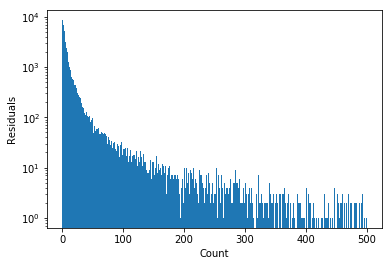

In [35]:
y_predicted = linear.predict(X_test)
residuals_histogram(y_test,y_predicted)

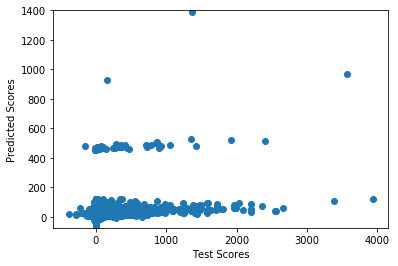

In [36]:
y_test_vs_y_predicted(y_test,y_predicted)

The last plot shows that most of the values are getting under-predicted. This is backed by the fact that the residuals plot also is skewed towards some very high values. As a result, the model has a pretty low `R-squared`, i.e., 0.07

### Lasso Regression

Let's try other versions of Linear Regression and see if at least they will make everything better. Basically, we're going to try the three popular versions:

* `Lasso Regression`
* `Ridge Regression`
* `Elastic Net Regression`

In [37]:
from sklearn.linear_model import LassoCV

In [38]:
lasso = LassoCV(cv=30).fit(X_train, y_train)
lasso.alpha_

169.20362692913852

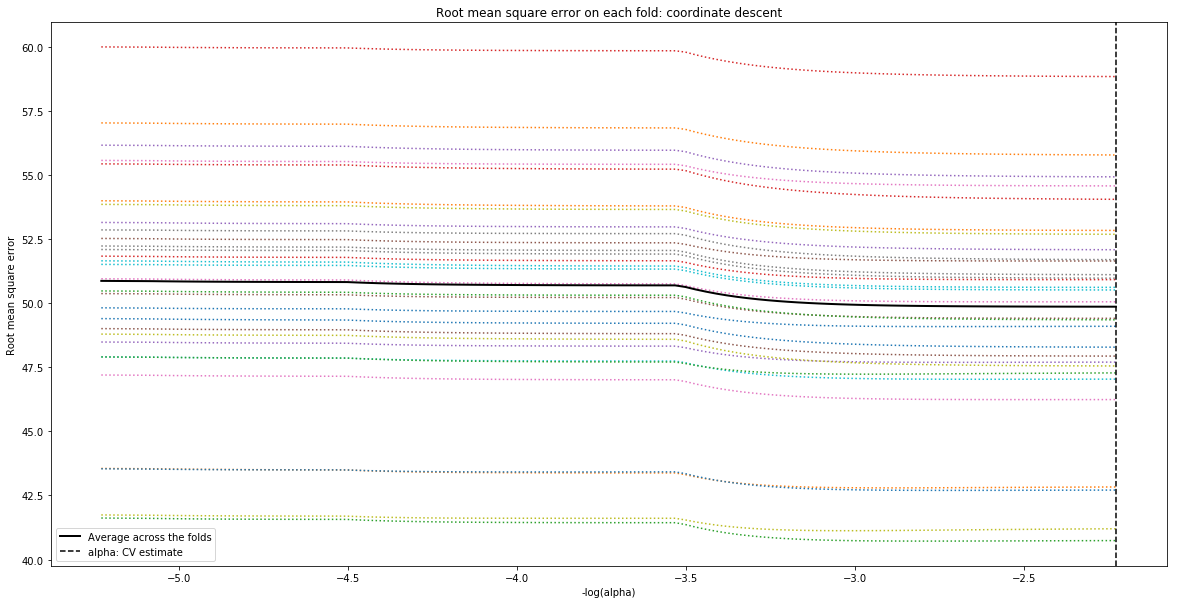

In [39]:
plot_coordinate_descent(lasso)

The coordinate descent plot for this case doesn't really give the impression that RMSEs are converging, hence, LassoCV might not help.

A quick look at the `R-squared` value will help you see that the lasso regression model actually makes things worse.

In [40]:
model_performance_dict["Lasso Regression"] = model_diagnostics(lasso)

R-Sq: 0.03973
RMSE: 48.534881743522526
MAE: 11.65703096475598


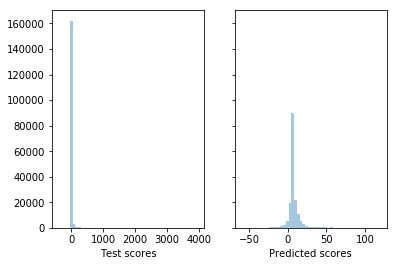

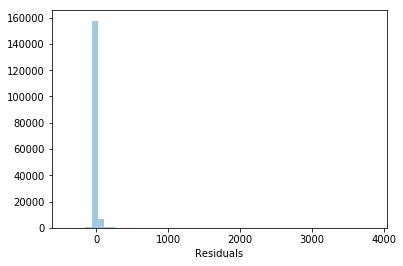

In [41]:
y_predicted = lasso.predict(X_test)
plot_residuals(y_test,y_predicted)

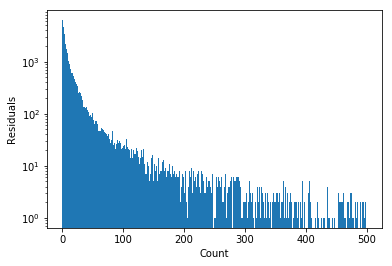

In [42]:
residuals_histogram(y_test,y_predicted)

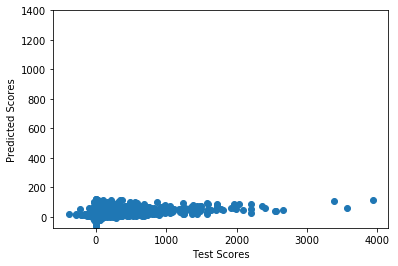

In [43]:
y_test_vs_y_predicted(y_test,y_predicted)

So the Lasso model still underpredicts, as is the case with linear regression. In fact, it loses the few points for which linear regression does a decent job, and hence loses even more in `R-squared`.

### Ridge Regression

Next, as stated earlier, we'll try Ridge Regression:

In [67]:
from sklearn.linear_model import RidgeCV

In [68]:
ridge = RidgeCV(cv=10).fit(X_train, y_train)
ridge.alpha_

10.0

In [69]:
model_performance_dict["Ridge Regression"] = model_diagnostics(ridge)

R-Sq: 0.07199
RMSE: 47.71278343792184
MAE: 11.82612305493355


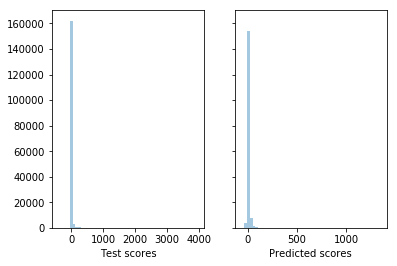

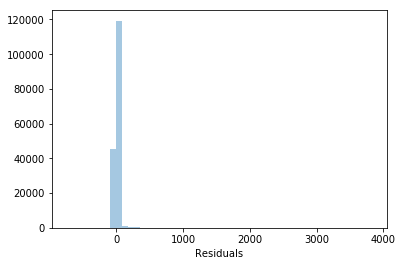

In [70]:
y_predicted = ridge.predict(X_test)
plot_residuals(y_test,y_predicted)

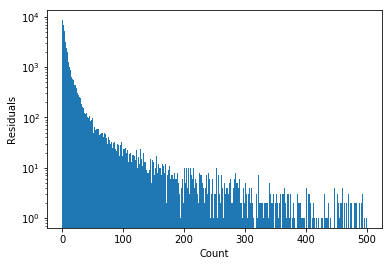

In [71]:
residuals_histogram(y_test,y_predicted)

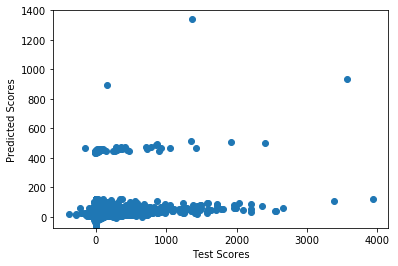

In [72]:
y_test_vs_y_predicted(y_test,y_predicted)

Risge Regression doesn't actually do any better than Linear Regression, as is shown by the above plot and by the fact that its `R-squared` value (**7.2%**) is only fractionally better than that for linear regression (**7.16%**).

### Elastic Net Regression

Let's try one last model from the linear regression family of models - Elastic Net Regression

In [44]:
from sklearn.linear_model import ElasticNetCV

In [45]:
elastic_net = ElasticNetCV(cv = 30).fit(X_train, y_train)

In [46]:
elastic_net.alpha_

338.4072538582771

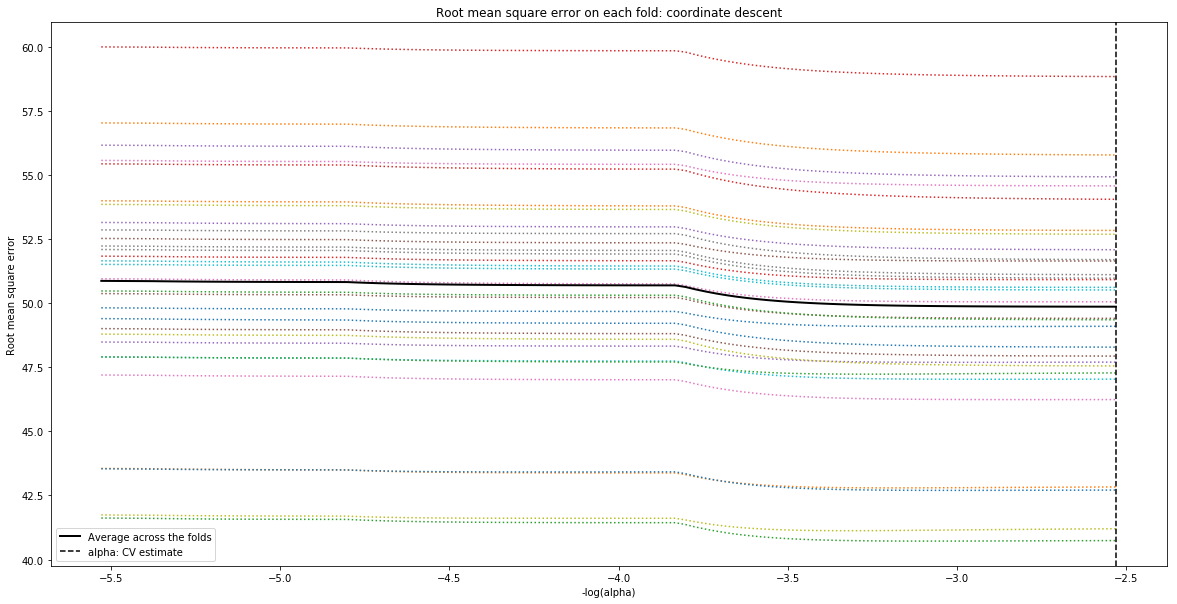

In [47]:
plot_coordinate_descent(elastic_net)

Just like Lasso regression, the coordinate descent plot here, by not convering even though it has a very high range of alphas to choose from, shows that ElasticNetCV might not really help in terms of `R-squared`.

In [48]:
model_performance_dict["Elastic Net Regression"] = model_diagnostics(elastic_net)

R-Sq: 0.03973
RMSE: 48.53490438428505
MAE: 11.656675597185762


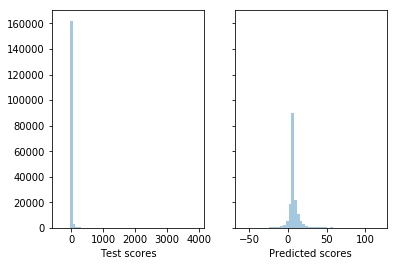

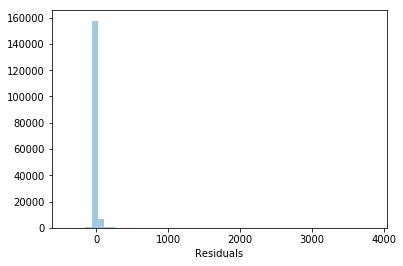

In [49]:
y_predicted = elastic_net.predict(X_test)
plot_residuals(y_test,y_predicted)

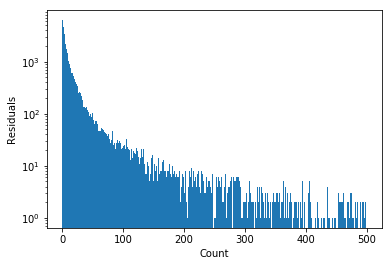

In [50]:
residuals_histogram(y_test,y_predicted)

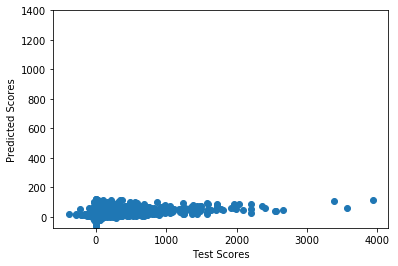

In [51]:
y_test_vs_y_predicted(y_test,y_predicted)

This model performs similarly to Lasso Regression, and hence, doesn't bring much to the table. Let's move to more complex models.

### KNN Regressor

The first non-linear model we'll fit, is KNN Regressors. Let's see how that works:

In [58]:
from sklearn.neighbors import KNeighborsRegressor

In [59]:
knr = KNeighborsRegressor()
knr.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=5, p=2,
          weights='uniform')

In [60]:
model_performance_dict["KNN Regression"] = model_diagnostics(knr)

R-Sq: 0.1159
RMSE: 46.570295853810116
MAE: 9.89428075426519


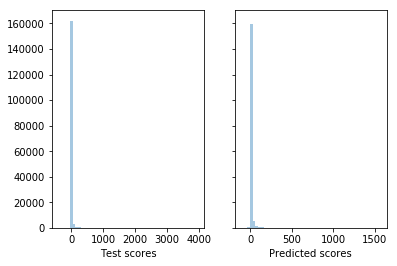

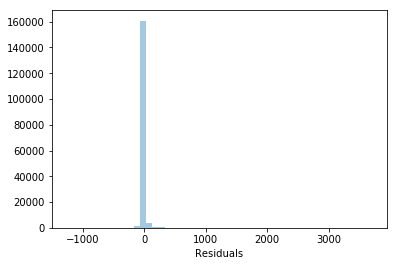

In [61]:
y_predicted = knr.predict(X_test)
plot_residuals(y_test,y_predicted)

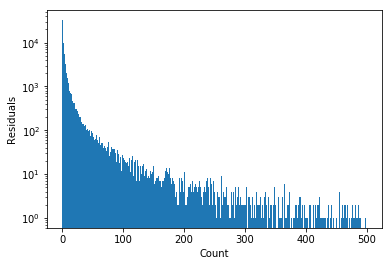

In [62]:
residuals_histogram(y_test,y_predicted)

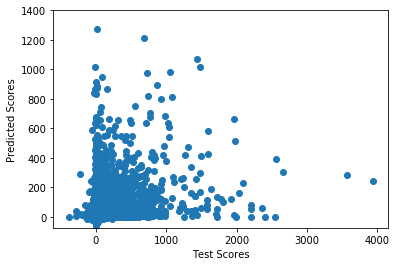

In [63]:
y_test_vs_y_predicted(y_test,y_predicted)

`R-squared` for this model is 0.1159, which is definitely a good improvement on the linear regression model's performance. The main difference between the two models is that now we actually have many more data points for which a high score is predicted.

Let's move on to tree-based models and see if they can perform better.

### Decision Tree Regression

For decision trees, we went with:
* `min_samples_leaf` = `45`
* `min_samples_split` = `45`

These numbers were chosen using cross validation. An explanation for that can be found under **Section 4: Parameter Tuning**.

In [52]:
from sklearn.tree import DecisionTreeRegressor

In [53]:
dt = DecisionTreeRegressor(min_samples_split=45, min_samples_leaf=45, random_state = 10)
dt.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=45,
           min_samples_split=45, min_weight_fraction_leaf=0.0,
           presort=False, random_state=10, splitter='best')

In [54]:
model_performance_dict["Decision Tree"] = model_diagnostics(dt)

R-Sq: 0.2353
RMSE: 43.31134868554883
MAE: 8.528434821661437


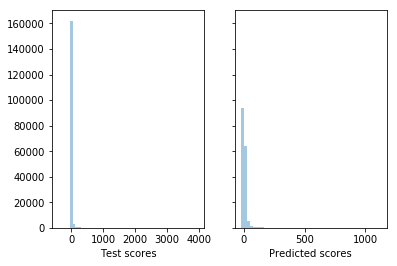

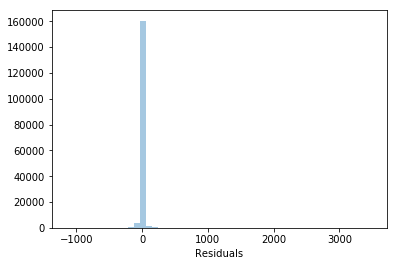

In [55]:
y_predicted = dt.predict(X_test)
plot_residuals(y_test,y_predicted)

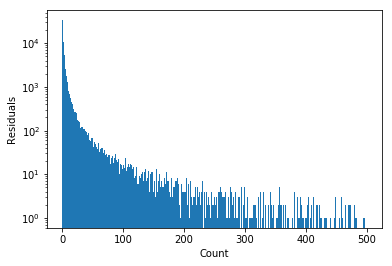

In [56]:
residuals_histogram(y_test,y_predicted)

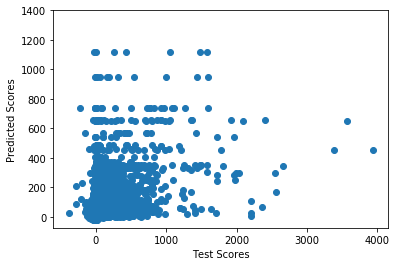

In [57]:
y_test_vs_y_predicted(y_test,y_predicted)

Decision Trees, with their inherent non-linearity are able to model this data better. They do predict higher scores for a substantial amount of the data, and that shows in the `R-squared` value (**23.53%**).

In [170]:
dt_feature_imps = get_feature_importance(dt)

parent_score                  : 28.67%
time_since_parent             : 23.51%
no_of_past_comments           : 14.69%
comment_tree_root_score       :  9.34%
gilded                        :  5.66%
time_since_comment_tree_root  :  4.30%
controversiality              :  2.17%
link_score                    :  1.96%
title_cosine                  :  1.81%
time_since_link               :  1.45%
word_counts                   :  1.15%
senti_neg                     :  1.10%
title_euc                     :  1.00%
parent_euc                    :  0.52%
senti_comp                    :  0.45%
senti_neu                     :  0.39%
upvote_ratio                  :  0.38%
hour_of_comment               :  0.33%
depth                         :  0.29%
parent_cosine                 :  0.18%
senti_pos                     :  0.14%
subreddit_food                :  0.10%
is_flair_css                  :  0.07%
no_of_linked_urls             :  0.05%
title_url_in_top              :  0.03%
is_edited                

The above gives a list of the most important features for the decision tree model. Instead of discussing these features at length here, though, we have chosen to interpret them later, for XG Boost, as that is our best performing model.

### Random Forest Regression

Parameters for Random Forest are:
* `min_samples_leaf` = `10`
* `min_samples_split` = `70`

Again, an explanation for the cross validation can be found under **Section 4: Parameter Tuning**.

In [73]:
from sklearn.ensemble import RandomForestRegressor

In [74]:
rf = RandomForestRegressor(n_jobs=-1, n_estimators=70, min_samples_leaf=10, random_state = 10)
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=10, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=70, n_jobs=-1,
           oob_score=False, random_state=10, verbose=0, warm_start=False)

In [75]:
model_performance_dict["Random Forest"] = model_diagnostics(rf)

R-Sq: 0.3071
RMSE: 41.22904198714311
MAE: 8.06610998410602


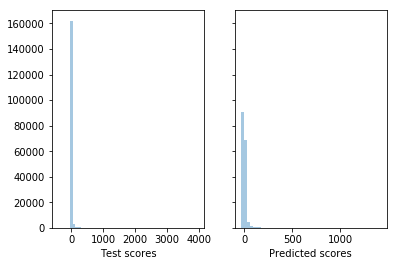

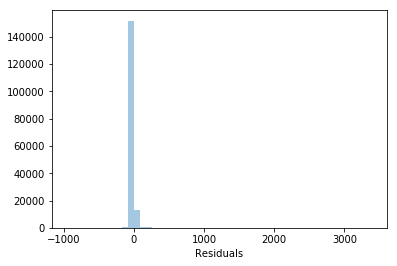

In [76]:
y_predicted = rf.predict(X_test)
plot_residuals(y_test,y_predicted)

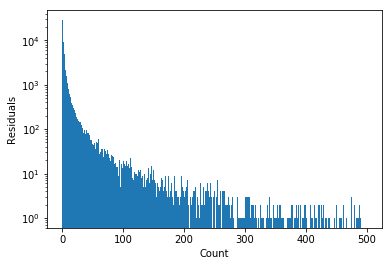

In [77]:
residuals_histogram(y_test,y_predicted)

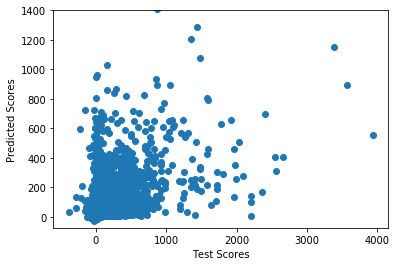

In [78]:
y_test_vs_y_predicted(y_test,y_predicted)

Random Forests's scatter plot looks pretty much the same as the one for Decision Trees, except for one fact: Decision Trees were predicting high values for quite a few comments that were supposed to get low values, but Random Forests succeed in avoiding that and hence, have a greater `R-squared` value (**30.7%**).

In [143]:
rf_feature_imps = get_feature_importance(rf)

parent_score                  : 31.34%
time_since_parent             : 23.45%
no_of_past_comments           : 15.24%
comment_tree_root_score       :  7.52%
time_since_comment_tree_root  :  6.21%
link_score                    :  2.46%
controversiality              :  2.22%
time_since_link               :  1.57%
gilded                        :  1.37%
title_euc                     :  1.25%
word_counts                   :  1.04%
title_cosine                  :  0.86%
parent_cosine                 :  0.81%
parent_euc                    :  0.73%
senti_neu                     :  0.69%
senti_neg                     :  0.58%
senti_comp                    :  0.51%
upvote_ratio                  :  0.47%
senti_pos                     :  0.42%
is_edited                     :  0.21%
depth                         :  0.17%
hour_of_comment               :  0.12%
is_flair_css                  :  0.12%
subreddit_food                :  0.09%
is_selftext                   :  0.06%
no_of_linked_urls        

Again, we choose to explain the most important features after XG Boost finishes, but in case you're interested to look at the features for Random Forests, you can find them here.

### Gradient Boosting Regressor

Let's try some boosting techniques:
* Gradient Boosting Regressor
* XG Boost Regressor

In [102]:
from sklearn.ensemble import GradientBoostingRegressor

In [103]:
gbr = GradientBoostingRegressor(n_estimators=70, max_depth=5)
gbr.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=5, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=70, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [104]:
model_performance_dict["Gradient Boosting Regression"] = model_diagnostics(gbr)

R-Sq: 0.3061
RMSE: 41.258489678563144
MAE: 8.327943190386048


Gradient Boosting, despite several tries at "Student Gradient Descent", doesn't perform any better than Random Forests. Let's just directly move on to XG Boost models.

### XGBoost Regressor

In [108]:
import xgboost

In [109]:
xgb = xgboost.XGBRegressor(n_estimators=70, max_depth=5,n_jobs=-1)
xgb.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=70,
       n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [110]:
model_performance_dict["XG Boosted Regression"] = model_diagnostics(xgb)

R-Sq: 0.3123
RMSE: 41.0719063825497
MAE: 8.32400577164756


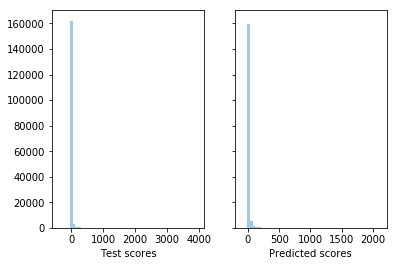

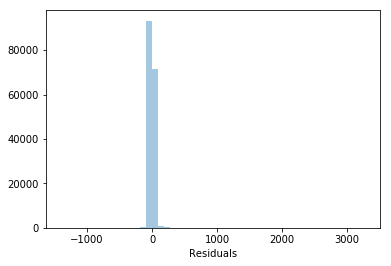

In [111]:
y_predicted = xgb.predict(X_test)
plot_residuals(y_test,y_predicted)

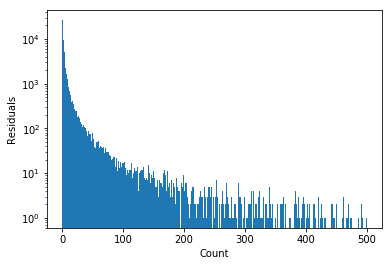

In [112]:
residuals_histogram(y_test,y_predicted)

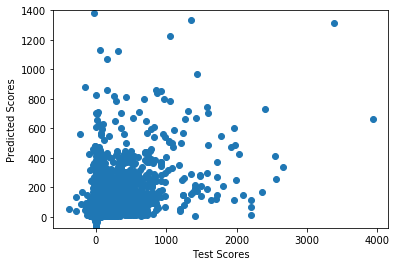

In [113]:
y_test_vs_y_predicted(y_test,y_predicted)

In [121]:
xgb_feature_imps = get_feature_importance(xgb)

parent_score                  : 26.54%
time_since_parent             : 10.29%
no_of_past_comments           :  9.65%
time_since_link               :  8.75%
time_since_comment_tree_root  :  5.60%
comment_tree_root_score       :  5.20%
gilded                        :  4.60%
upvote_ratio                  :  4.20%
link_score                    :  3.85%
controversiality              :  3.75%
parent_euc                    :  2.10%
title_euc                     :  1.60%
word_counts                   :  1.40%
title_cosine                  :  1.40%
parent_cosine                 :  1.30%
depth                         :  1.10%
no_of_linked_urls             :  0.90%
senti_pos                     :  0.90%
senti_comp                    :  0.85%
is_edited                     :  0.80%
subjectivity                  :  0.75%
hour_of_comment               :  0.70%
senti_neu                     :  0.65%
senti_neg                     :  0.50%
no_of_quoted_users            :  0.30%
distinguished_admin      

Looks like `XGBoost` `Regressor` is our best performing model.

A quick look at the feature importance here, gives you the sense that your score doesn't really depend much on what you write but more on tree - related features, showing where the comment is in the tree, and which comment tree the comment belongs to, which intuitively makes sense.

Features like `controversiality`, `word_counts` of the coment also contribute in a non-insignificant matter. So your score does depend a little bit on your actual text, but that is clearly not the deciding factor.

## Parameter Tuning

In [179]:
from parfit import bestFit
from sklearn.model_selection import ParameterGrid

### Decision Trees

In [180]:
params = {
    "min_samples_split": np.arange(35,55,5),
    "min_samples_leaf": np.arange(35,55,5)
}

-------------CROSS-VALIDATING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done  11 out of  16 | elapsed: 12.6min remaining:  5.7min
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed: 15.9min remaining:  3.7min
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed: 16.4min finished


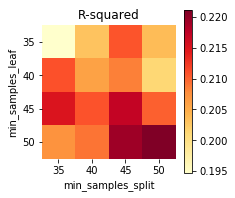

In [181]:
best_model, best_score, all_models, all_scores = bestFit(DecisionTreeRegressor(), ParameterGrid(params), 
                                                         X_train, y_train,
                                                         metric=r2_score, scoreLabel="R-squared")

We end up choosing both `min_samples_split` and `min_samples_leaf` to be 45. Any increase from that doesn't seem like it is increasing R squared as much as it introducing complexity.

### Random Forests

In [7]:
params = {
    "n_estimators": np.array([10,20]),
    "min_samples_leaf": np.array([10,20])
}

-------------CROSS-VALIDATING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed: 13.6min
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed: 14.1min remaining: 14.1min
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed: 20.9min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed: 20.9min finished


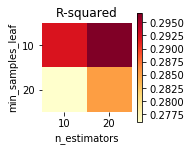

In [20]:
best_model, best_score, all_models, all_scores = bestFit(RandomForestRegressor(),
                                                         ParameterGrid(params), X_train,
                                                         y_train,
                                                         metric=r2_score,
                                                         scoreLabel="R-squared")

In [8]:
params = {
    "n_estimators": np.array([50,70]),
    "min_samples_leaf": np.array([50,30])
}

-------------CROSS-VALIDATING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed: 60.9min
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed: 62.4min remaining: 62.4min
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed: 74.9min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed: 74.9min finished


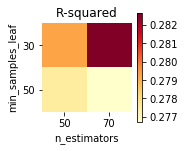

In [25]:
best_model, best_score, all_models, all_scores = bestFit(RandomForestRegressor(),
                                                         ParameterGrid(params), X_train,
                                                         y_train,
                                                         metric=r2_score,
                                                         scoreLabel="R-squared")

We'll choose `min_samples_leaf` as 10. Going below that might help the performance, but would be overfitting.

Also, we'll choose `n_estimators`'s value to be 70. Increasing it too much doesn't look it's increasing performance that much.

## Model Comparison

At last, we can now compare the performance of our models. We'll define a function for that, so we don't have to write code again and again:

In [65]:
def model_comparison(model_performance_dict, sort_by = 'RMSE', metric = 'RMSE'):

    Rsq_list = []
    RMSE_list = []
    MAE_list = []
    for key in model_performance_dict.keys():
        Rsq_list.append(model_performance_dict[key][0])
        RMSE_list.append(model_performance_dict[key][1])
        MAE_list.append(model_performance_dict[key][2])

    props = pd.DataFrame([])

    props["R-squared"] = Rsq_list
    props["RMSE"] = RMSE_list
    props["MAE"] = MAE_list
    props.index = model_performance_dict.keys()
    props = props.sort_values(by = sort_by)

    fig, ax = plt.subplots(figsize = (12,6))

    ax.bar(props.index, props[metric], color="blue")
    plt.title(metric)
    plt.xlabel('Model')
    plt.xticks(rotation = 45)
    plt.ylabel(metric)

### RMSE

As we noted earlier, the RMSE of linear regression family models is not really an improvement on the Baseline. 

However, non-linear models definitely seem to be doing a much better job, KNN Regressor, the most simple non-linear model improves on the RMSE quite a bit, but this improvement is just taken to another level by the tree based models (Decision Trees, Random Forests, XG Boost Regressor, Gradient Boosting Regression)

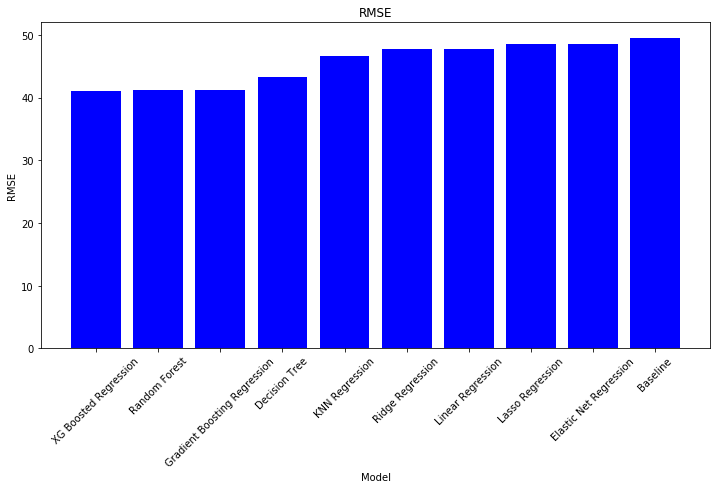

In [117]:
model_comparison(model_performance_dict, sort_by = 'RMSE', metric = 'RMSE')

### R Squared

The plot for R-squared values shows pretty much the same pattern as the one for RMSE values, except for the fact that the differences between the models look even more pronounced here.

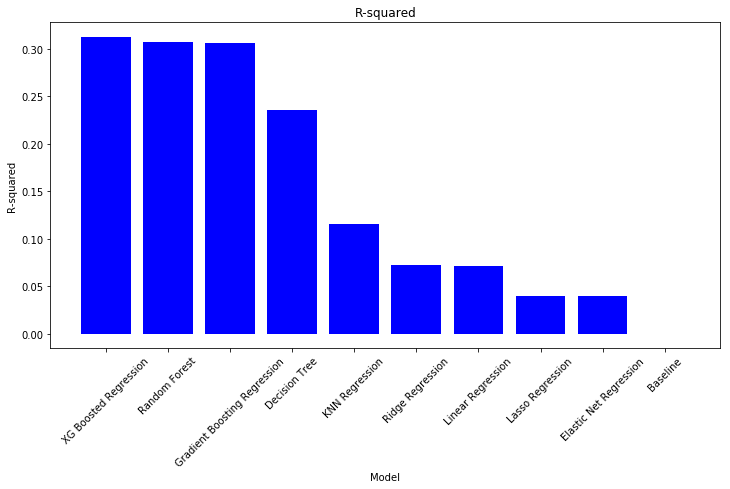

In [118]:
model_comparison(model_performance_dict, sort_by = 'RMSE', metric = 'R-squared')

### MAE

MAE also roughly follows the same trend - a decrease in value as complexity is increased.

Although, one must note that the values here are in the ranges of 10s, as opposed to RMSEs, that are in ranges of 30s.

That is probably because RMSEs penalise large deviations strictly, and hence, given our target variable's range, might just have been inherently very high.

Hence, hopefully the plot below will illustrate that the models are actually performing pretty decently.

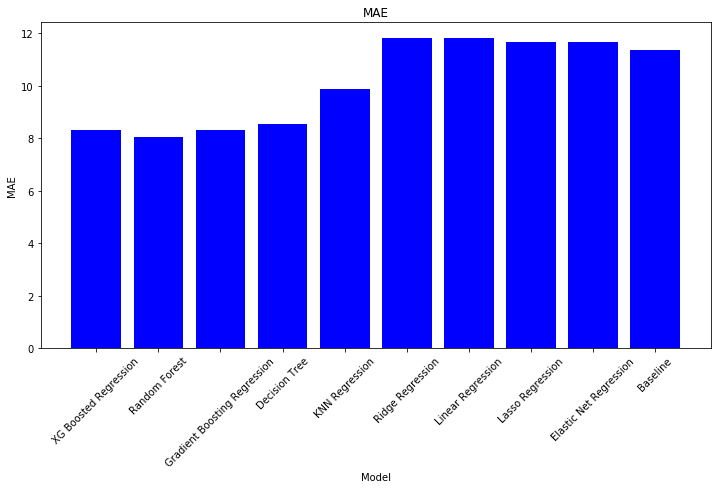

In [119]:
model_comparison(model_performance_dict, sort_by = 'RMSE', metric = 'MAE')